In [132]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torchsummary import summary

# Data Reading and Processing

In [133]:
trainset_path = "archive\\OCT2017_\\train"
testset_path = "archive\\OCT2017_\\test"

batch_size = 32
image_size = 128

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_val_dataset = datasets.ImageFolder(trainset_path, transform=train_transforms)
train_dataset, valid_dataset = random_split(train_val_dataset, [len(train_val_dataset)-1000, 1000])
test_dataset = datasets.ImageFolder(testset_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

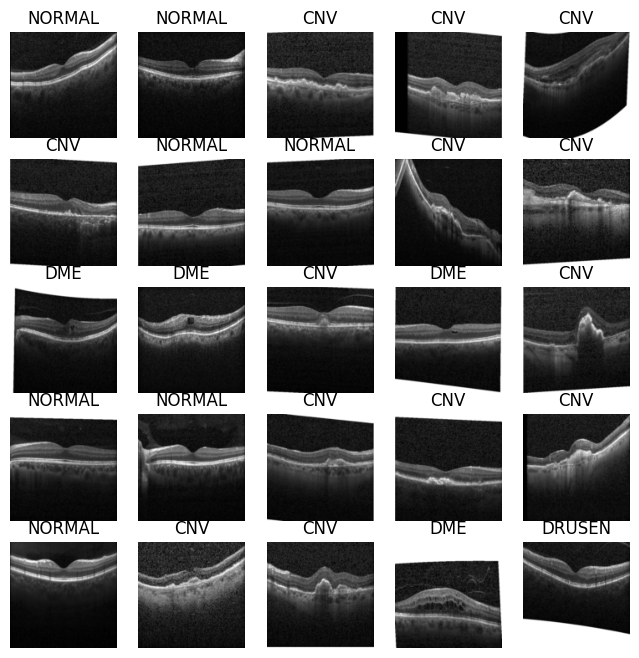

In [189]:
class_labels=["CNV","DME","DRUSEN","NORMAL"]
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

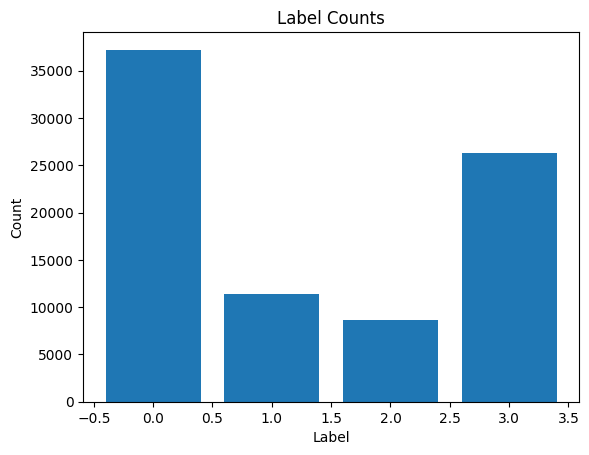

In [152]:
label_counts = {}
for _, label in train_val_dataset:
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1



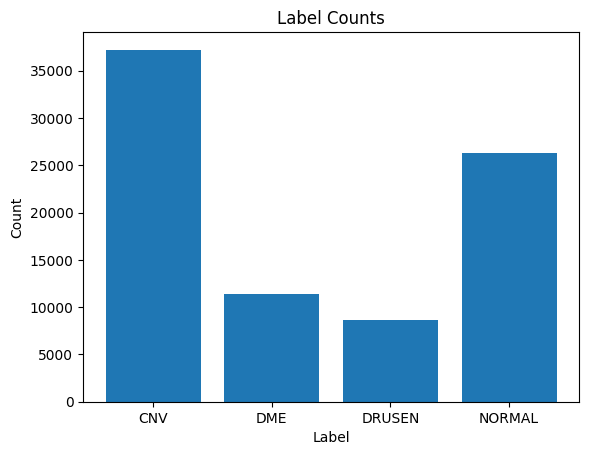

In [190]:
plt.bar(class_labels, label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks()
plt.title('Label Counts')
plt.show()

# Model Constructing

## Resnet: Residual Blocks

In [137]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

## Resnet: Resnet 18 Model

In [138]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        self.layer3 = self.make_layer(block, 256, layers[2], 2)
        self.layer4 = self.make_layer(block, 512, layers[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [139]:
num_classes = 4
resnet = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)
summary(resnet, (1,image_size, image_size))
# print(resnet)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          3,136
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─Sequential: 1-4                        [-1, 64, 64, 64]          --
|    └─ResidualBlock: 2-1                [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          128
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          128
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─ResidualBlock: 2-2                [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 64, 64]          36,8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          3,136
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─Sequential: 1-4                        [-1, 64, 64, 64]          --
|    └─ResidualBlock: 2-1                [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 64, 64]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 64, 64]          128
|    |    └─ReLU: 3-3                    [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 64, 64]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 64, 64]          128
|    |    └─ReLU: 3-6                    [-1, 64, 64, 64]          --
|    └─ResidualBlock: 2-2                [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 64, 64]          36,8

# Model Training

In [140]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [141]:
def train(model, train_loader, valid_loader, epochs = 10, lr = 0.001):

    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if batch_number%500 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over valid data
        for inputs, labels in valid_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the valid data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(valid_loader)
        epoch_acc = correct/total
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: valid loss: {epoch_loss:.4f}, valid accuracy: {epoch_acc:.4f}')
        torch.save(model.state_dict(), "resnet{}_statedict.pt".format(epoch))
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [142]:
model = resnet.to(device)
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, \
                                    train_loader, \
                                    valid_loader, \
                                    epochs = 32, \
                                    lr = 1e-3)

Epoch 1/32, Batch number: 0, Cumulated accuracy: 0.09375
Epoch 1/32, Batch number: 500, Cumulated accuracy: 0.7243013972055888
Epoch 1/32, Batch number: 1000, Cumulated accuracy: 0.7861513486513486
Epoch 1/32, Batch number: 1500, Cumulated accuracy: 0.8192038640906063
Epoch 1/32, Batch number: 2000, Cumulated accuracy: 0.8413137181409296
Epoch 1/32, Batch number: 2500, Cumulated accuracy: 0.8549205317872851
--- Epoch 1/32: Train loss: 0.4078, Train accuracy: 0.8570
--- Epoch 1/32: valid loss: 0.4312, valid accuracy: 0.8460
Epoch 2/32, Batch number: 0, Cumulated accuracy: 1.0
Epoch 2/32, Batch number: 500, Cumulated accuracy: 0.9225299401197605
Epoch 2/32, Batch number: 1000, Cumulated accuracy: 0.9244193306693307
Epoch 2/32, Batch number: 1500, Cumulated accuracy: 0.9256120919387075
Epoch 2/32, Batch number: 2000, Cumulated accuracy: 0.9262400049975013
Epoch 2/32, Batch number: 2500, Cumulated accuracy: 0.9278788484606157
--- Epoch 2/32: Train loss: 0.2136, Train accuracy: 0.9278
--- E

In [145]:
torch.save(model, "resnet_fullmodel.pt")

In [147]:
model.load_state_dict(torch.load("resnet7_statedict.pt"))

<All keys matched successfully>

# Model Evaluating

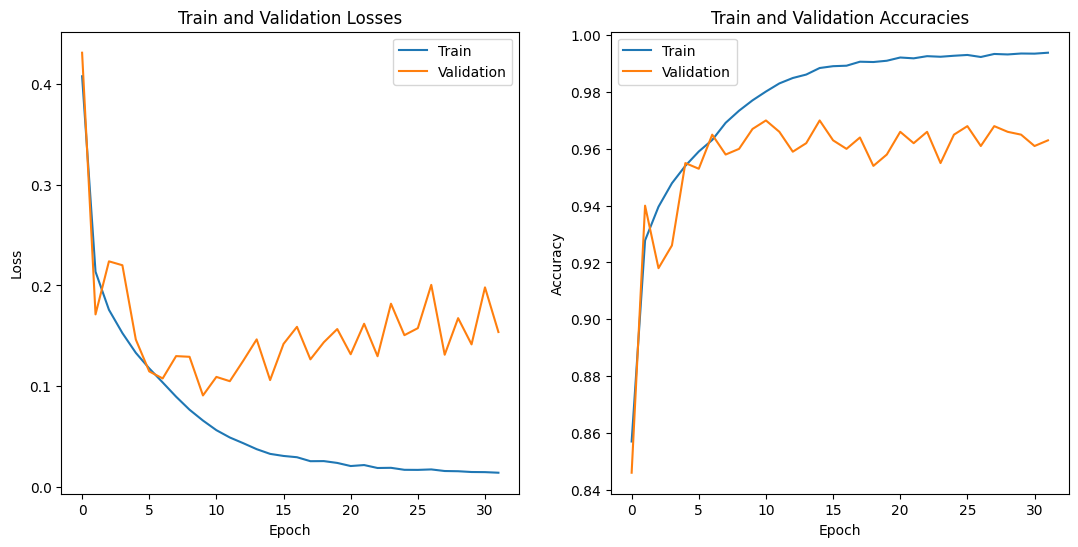

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax1.plot(train_losses, label='Train')
ax1.plot(valid_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Losses')
ax1.legend()

ax2.plot(train_accuracies, label='Train')
ax2.plot(valid_accuracies, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Validation Accuracies')
ax2.legend()

plt.show()


In [148]:
def test(model, test_loader):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss /= len(valid_loader)
    epoch_acc = correct/total
    print(f'--- test loss: {epoch_loss:.4f}, test accuracy: {epoch_acc:.4f}')


In [149]:
test(model, test_loader)

--- test loss: 0.0085, test accuracy: 0.9990


In [153]:
from sklearn.metrics import confusion_matrix
import numpy as np

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [171]:
def get_pred(model, test_loader):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
        y_pred_list.append(predicted.cpu())
        y_true_list.append(labels.cpu())
        y_pred = torch.cat(y_pred_list, dim=0)
        y_true = torch.cat(y_true_list, dim=0)
    return y_true, y_pred

In [176]:
y_true, y_pred = get_pred(model, test_loader)
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

In [182]:
y2_true, y2_pred = get_pred(model, train_loader)
cm2 = confusion_matrix(y2_true.numpy(), y2_pred.numpy())

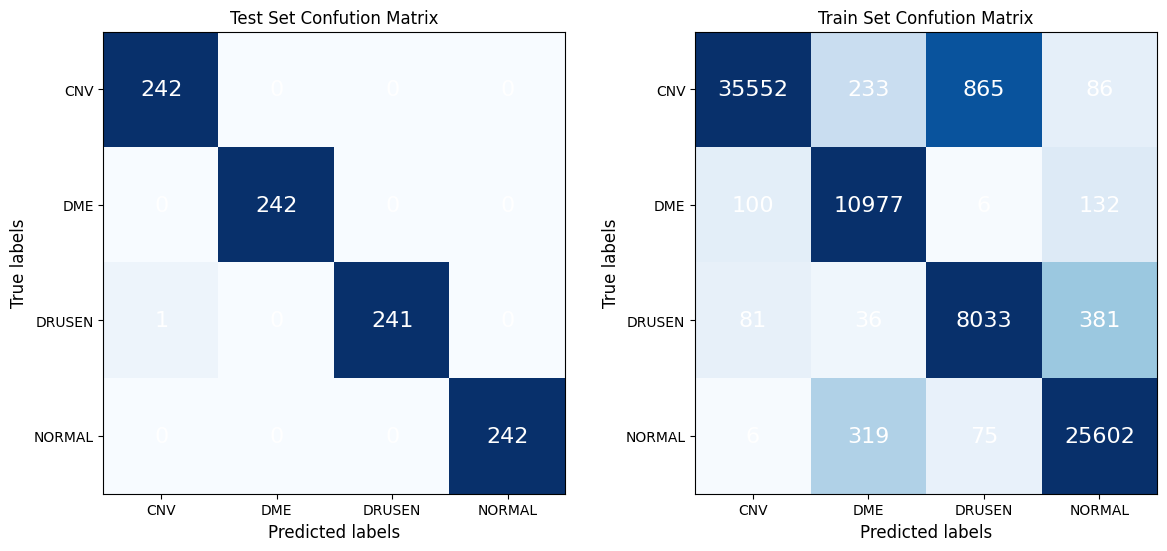

In [195]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 6))
ax1.imshow(cm, cmap='Blues', vmin=0, vmax=20)
ax1.grid(False)
ax1.set_xlabel('Predicted labels', fontsize=12, color='black')
ax1.set_ylabel('True labels', fontsize=12, color='black')
ax1.set_xticks(np.arange(4))
ax1.set_yticks(np.arange(4))
ax1.set_xticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')
ax1.set_yticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')

for i in range(4):
    for j in range(4):
        ax1.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

ax2.imshow(cm2, cmap='Blues', vmin=0, vmax=1000)
ax2.grid(False)
ax2.set_xlabel('Predicted labels', fontsize=12, color='black')
ax2.set_ylabel('True labels', fontsize=12, color='black')
ax2.set_xticks(np.arange(4))
ax2.set_yticks(np.arange(4))
ax2.set_xticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')
ax2.set_yticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')

for i in range(4):
    for j in range(4):
        ax2.text(j, i, cm2[i, j], ha='center', va='center', color='white', fontsize=16)

ax1.set_title("Test Set Confution Matrix")
ax2.set_title("Train Set Confution Matrix")


plt.show()